In [1]:
CUDA_INDEX = 0
NAME = 'PubMed'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [4]:
preds = [
    ('NeuroGSim     ', torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}/nn_outer_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}/dual_outer_pred.pt', map_location='cpu')),
#     ('NeuroMatch    ', torch.as_tensor(np.load(f'../preds/{NAME}/nm_outer_pred.npy'))),
    ('H2MN-RW        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw_outer.npy'))),
    ('H2MN-NE        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne_outer.npy'))),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_outer_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}/b_outer_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}/f2_outer_pred.pt', map_location='cpu')),
]

In [5]:
outer_test_set = torch.load(f'/data/rishabh/neurosim/final/data/{NAME}/outer_test.pt', map_location='cpu')
queries, _, lb, ub = outer_test_set

In [6]:
def range_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    r = torch.arange(1, int(torch.max(lb).item()), 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(r, lb, ub, pred)
        viz.plot_summary(r, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('range')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = utils.nanmean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
#         print()

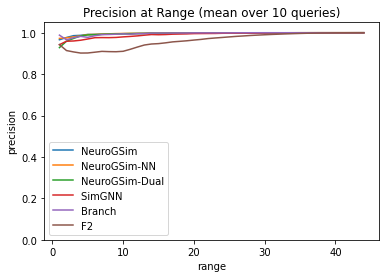

96.60 / 98.58 / 99.16 / 99.32 / 99.44
97.24 / 97.99 / 99.09 / 99.30 / 99.57
92.80 / 97.24 / 98.94 / 99.19 / 99.41
94.22 / 96.01 / 96.96 / 97.64 / 97.72
98.83 / 97.59 / 97.77 / 99.07 / 99.28
94.25 / 90.72 / 90.21 / 90.99 / 90.82


In [24]:
range_metrics(metrics.precision_at_range, lb, ub, preds,
              'precision', f'Precision at Range (mean over {len(queries)} queries)')

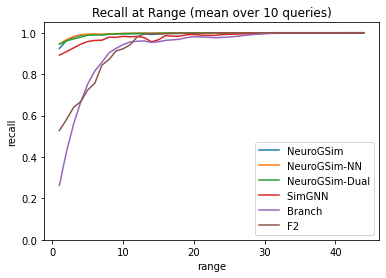

92.40 / 97.76 / 99.04 / 99.03 / 99.36
94.60 / 98.16 / 99.31 / 99.28 / 99.57
94.44 / 96.97 / 98.80 / 98.90 / 99.44
89.23 / 92.66 / 95.76 / 96.40 / 97.79
26.33 / 55.82 / 75.22 / 85.71 / 92.44
52.78 / 63.99 / 72.38 / 84.31 / 91.19


In [25]:
range_metrics(metrics.recall_at_range, lb, ub, preds,
              'recall', f'Recall at Range (mean over {len(queries)} queries)')

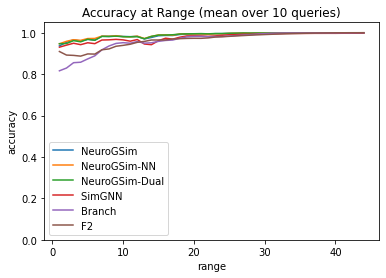

93.64 / 96.57 / 96.78 / 98.29 / 98.35
94.66 / 96.62 / 97.19 / 98.35 / 98.56
94.69 / 96.17 / 96.86 / 98.22 / 98.34
93.01 / 94.91 / 95.15 / 96.47 / 96.79
81.61 / 85.52 / 87.35 / 91.73 / 94.83
90.92 / 89.05 / 89.76 / 91.75 / 93.46


In [26]:
range_metrics(metrics.accuracy_at_range, lb, ub, preds,
              'accuracy', f'Accuracy at Range (mean over {len(queries)} queries)')

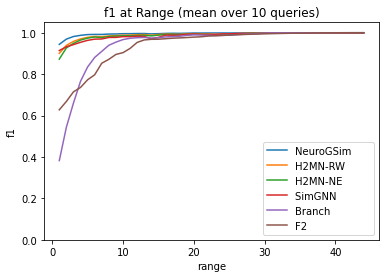

94.38 / 98.17 / 99.10 / 99.17 / 99.40
90.01 / 95.82 / 97.77 / 98.10 / 98.61
87.26 / 94.84 / 97.37 / 97.68 / 98.35
91.39 / 94.26 / 96.32 / 96.98 / 97.74
38.24 / 66.02 / 83.46 / 91.00 / 95.44
62.77 / 71.43 / 77.27 / 85.27 / 89.52


In [7]:
range_metrics(metrics.f1_at_range, lb, ub, preds,
              'f1', f'f1 at Range (mean over {len(queries)} queries)')

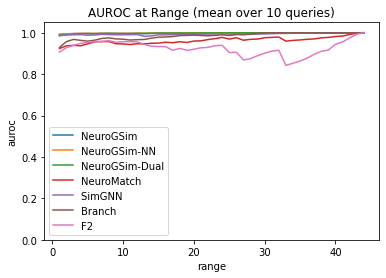

99.16 / 99.57 / 99.61 / 99.67 / 99.61
99.33 / 99.60 / 99.69 / 99.71 / 99.67
98.61 / 99.35 / 99.54 / 99.62 / 99.60
92.36 / 93.90 / 94.65 / 95.69 / 94.67
98.53 / 99.00 / 98.81 / 99.20 / 98.99
92.89 / 96.78 / 95.92 / 97.23 / 97.01
90.67 / 93.92 / 95.31 / 95.83 / 95.41


In [7]:
range_metrics(metrics.auroc_at_range, lb, ub, preds,
              'auroc', f'AUROC at Range (mean over {len(queries)} queries)')

# 